In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

import nltk
import os
import shutil
local_nltk_path = os.path.join(os.getcwd(), "nltk_data")
shutil.rmtree(local_nltk_path, ignore_errors=True)
os.makedirs(local_nltk_path, exist_ok=True)
nltk.data.path.clear()
nltk.data.path.append(local_nltk_path)
nltk.download('stopwords', download_dir=local_nltk_path)
nltk.download('punkt', download_dir=local_nltk_path)
nltk.download('punkt_tab', download_dir=local_nltk_path)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import spacy

from datasets import load_dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 2/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 2/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 2/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Exactitud con BoW: 0.8263030303030303
Exactitud con TF-IDF: 0.8317575757575758


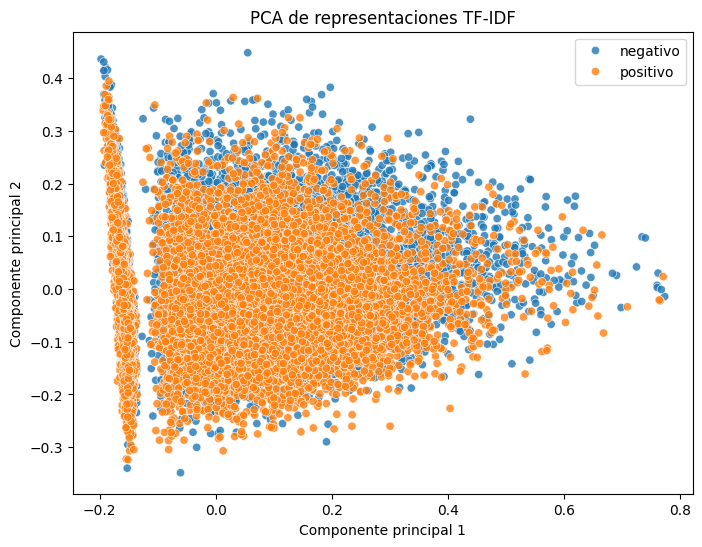

Varianza explicada: [0.03121482 0.01257074]
Exactitud (solo TF-IDF): 0.8317575757575758

Reporte de clasificación:
               precision    recall  f1-score   support

    negativo       0.84      0.82      0.83      4117
    positivo       0.83      0.84      0.83      4133

    accuracy                           0.83      8250
   macro avg       0.83      0.83      0.83      8250
weighted avg       0.83      0.83      0.83      8250



In [3]:

## 2. Preprocesamiento y vectorización de texto

# Usar dataset IMDb (inglés) como fuente de sentimientos

data = load_dataset("imdb", split="train")
textos = data["text"]
etiquetas = ["positivo" if l == 1 else "negativo" for l in data["label"]]

stop_words = set(stopwords.words('english'))
def preprocesar(doc):
    return ' '.join([w.lower() for w in word_tokenize(doc) if w.isalpha() and w.lower() not in stop_words])

textos_limpios = [preprocesar(t) for t in textos]

vectorizador_bow = CountVectorizer(max_features=1000)
X_bow = vectorizador_bow.fit_transform(textos_limpios)

vectorizador_tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizador_tfidf.fit_transform(textos_limpios)

## 3. Comparación BoW vs TF-IDF con Naive Bayes

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, etiquetas, test_size=0.33, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, etiquetas, test_size=0.33, random_state=42)

modelo_bow = MultinomialNB().fit(X_train_bow, y_train)
pred_bow = modelo_bow.predict(X_test_bow)

modelo_tfidf = MultinomialNB().fit(X_train_tfidf, y_train)
pred_tfidf = modelo_tfidf.predict(X_test_tfidf)

print("Exactitud con BoW:", accuracy_score(y_test, pred_bow))
print("Exactitud con TF-IDF:", accuracy_score(y_test, pred_tfidf))

## 4. Visualización con PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=etiquetas, alpha=0.8)
plt.title("PCA de representaciones TF-IDF")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend()
plt.show()

print("Varianza explicada:", pca.explained_variance_ratio_)

## 5. Clasificador Naive Bayes con TF-IDF

modelo_nb = MultinomialNB()
modelo_nb.fit(X_train_tfidf, y_train)
predicciones = modelo_nb.predict(X_test_tfidf)

print("Exactitud (solo TF-IDF):", accuracy_score(y_test, predicciones))
print("\nReporte de clasificación:\n", classification_report(y_test, predicciones))

In [4]:
!python -m spacy download es_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 1.8 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


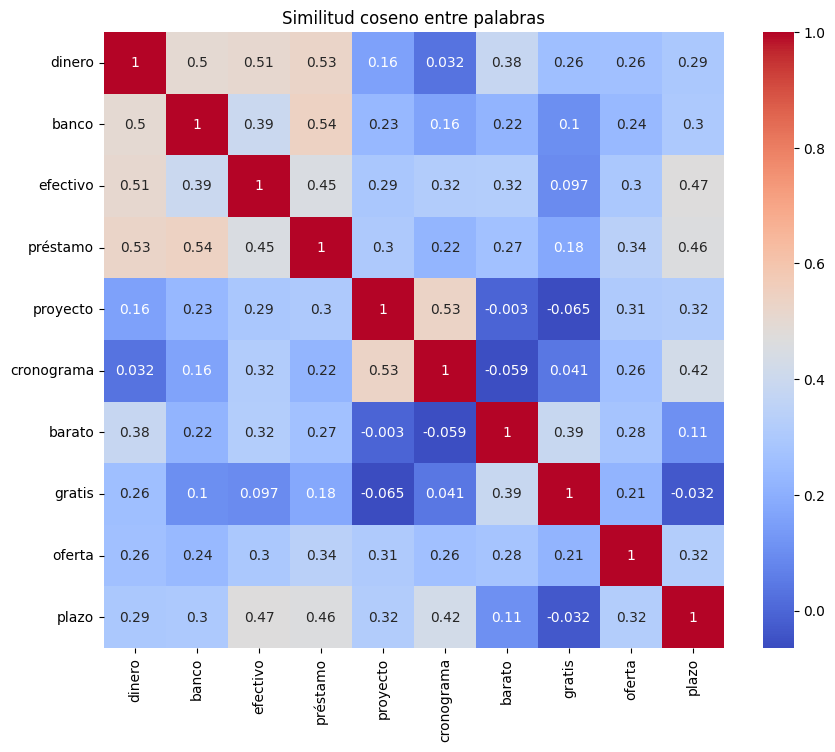

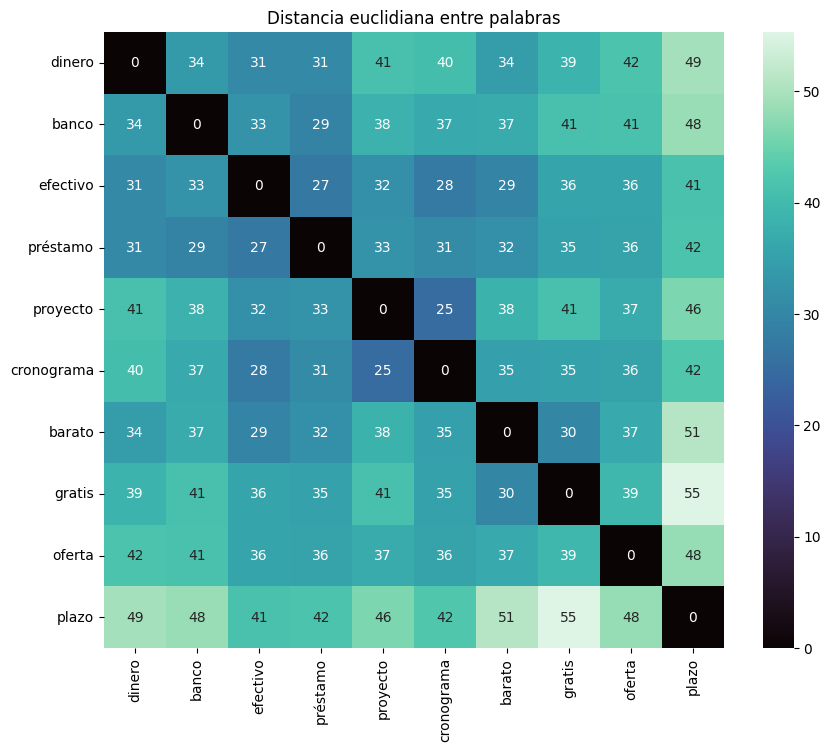

In [5]:
# Load Spanish model with word vectors
nlp = spacy.load("es_core_news_md")

# List of Spanish words to compare
palabras = ["dinero", "banco", "efectivo", "préstamo", "proyecto", "cronograma", "barato", "gratis", "oferta", "plazo"]

# Check for missing vectors (not all words may have one)
vectores = []
palabras_validas = []

for palabra in palabras:
    token = nlp(palabra)[0]
    if token.has_vector:
        vectores.append(token.vector)
        palabras_validas.append(palabra)
    else:
        print(f"⚠️ La palabra '{palabra}' no tiene vector y será omitida.")

vectores = np.array(vectores)

# Compute cosine similarity and Euclidean distance
sim_cos = cosine_similarity(vectores)
dist_euc = euclidean_distances(vectores)

# Heatmaps
plt.figure(figsize=(10, 8))
sns.heatmap(sim_cos, xticklabels=palabras_validas, yticklabels=palabras_validas, annot=True, cmap="coolwarm")
plt.title("Similitud coseno entre palabras")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(dist_euc, xticklabels=palabras_validas, yticklabels=palabras_validas, annot=True, cmap="mako")
plt.title("Distancia euclidiana entre palabras")
plt.show()